In [7]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

import numpy as np
from PIL import Image
import os 
from numba import cuda
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.client import device_lib

from sklearn.cluster import KMeans
from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import cv2

In [4]:
gpu_options = tf.GPUOptions(allow_growth=True)
custom_config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, gpu_options=gpu_options)
custom_config.gpu_options.allocator_type = 'BFC'
custom_config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.InteractiveSession(config=custom_config)

device_lib.list_local_devices()

c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15533262049791781806, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7730941132
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11900623240235185217
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [8]:
## Data loading 

# trainData = "C:/Users/mostafaosama2/Desktop/regressionSet/train"
# trainData = "../../../autoenctrain/train"
# testData = "C:/Users/mostafaosama2/Desktop/regressionSet/test"
# testData = "../../../autoenctrain/test"

datadir = "C:/Users/mostafaosama2/Desktop/autoenctrain/60k"

trainData = datadir + "/train"
testData = datadir + "/test"


new_train = []
new_test = []

for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(trainData, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        new_train.append(np.asarray( resized_image, dtype="uint8" ))

for filename in os.listdir(testData):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(testData, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96))
        new_test.append(np.asarray( resized_image, dtype="uint8" ))


In [9]:
## Data preprocessing

x_train = np.asarray(new_train)
x_test = np.asarray(new_test)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [10]:
print(x_train.shape)
print(x_test.shape)

(49000, 96, 96, 3)
(16000, 96, 96, 3)


In [11]:
n_epochs = 1000
batch_size = 32
optimizer = 'adam'
loss = 'mean_squared_error'

input_img = Input(shape=(96, 96, 3))  # adapt this if using `channels_first` image data format

encoder = Conv2D(filters=16, kernel_size=(3,3),strides=1, padding='same')(input_img)#x^2*16
encoder = LeakyReLU()(encoder)
encoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(encoder)#x^2*32
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(filters=64, kernel_size=(3,3),strides=2, padding='same')(encoder)#(x/2)^2*64
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling2D()(encoder)#(x/4)^2*64
encoder = Conv2D(filters=128, kernel_size=(3,3),strides=2, padding='same')(encoder)#(x/8)^2*128
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling2D()(encoder)#(x/16)^2*64
encoder = Conv2D(filters=64, kernel_size=(3,3),strides=1, padding='same')(encoder)#(x/16)^2*64
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(encoder)#(x/16)^2*32
encoder = LeakyReLU()(encoder)


bottleneck = Conv2D(filters=16, kernel_size=(1,1),strides=1, padding='same')(encoder)#(x/16)^2*16
bottleneck = LeakyReLU()(bottleneck)


decoder = Conv2D(filters=32, kernel_size=(1,1),strides=1, padding='same')(bottleneck)#(x/16)^2*32
decoder = LeakyReLU()(decoder)
decoder = Conv2D(filters=64, kernel_size=(3,3),strides=1, padding='same')(decoder)#(x/16)^2*64
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D()(decoder)#(x/8)^2*64
decoder = Conv2DTranspose(filters=128, kernel_size=(3,3),strides=2, padding='same')(decoder)#(x/4)^2*128
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D()(decoder)#(x/2)^2*128
decoder = Conv2DTranspose(filters=64, kernel_size=(3,3),strides=2, padding='same')(decoder)#x^2*64
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*32
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2D(filters=16, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*16
decoder = LeakyReLU()(decoder)
decoder = Conv2D(filters=3, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*3
decoded = LeakyReLU()(decoder)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer , loss=loss)

filepath = "C:/Users/mostafaosama2/Desktop/PathologyFinal/February_epochs{}_batch{}_{}.h5".format(n_epochs,batch_size,optimizer)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min', restore_best_weights=True)

callbacks_list = [checkpoint, ES]


In [12]:
with tf.device('/GPU:0'):
    autoencoder_train = autoencoder.fit(x_train, x_train,
                                        epochs=n_epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        validation_data=(x_test, x_test),
                                        callbacks=callbacks_list
                                       )


Train on 49000 samples, validate on 16000 samples
Epoch 1/1000
49000/49000 [==============================] - 223s 5ms/step - loss: 0.0347 - val_loss: 0.0285

Epoch 00001: val_loss improved from inf to 0.02852, saving model to C:/Users/mostafaosama2/Desktop/PathologyFinal/February_epochs1000_batch32_adam.h5
Epoch 2/1000
49000/49000 [==============================] - 213s 4ms/step - loss: 0.0275 - val_loss: 0.0263

Epoch 00002: val_loss improved from 0.02852 to 0.02635, saving model to C:/Users/mostafaosama2/Desktop/PathologyFinal/February_epochs1000_batch32_adam.h5
Epoch 3/1000
49000/49000 [==============================] - 204s 4ms/step - loss: 0.0249 - val_loss: 0.0236

Epoch 00003: val_loss improved from 0.02635 to 0.02363, saving model to C:/Users/mostafaosama2/Desktop/PathologyFinal/February_epochs1000_batch32_adam.h5
Epoch 4/1000
49000/49000 [==============================] - 204s 4ms/step - loss: 0.0234 - val_loss: 0.0236

Epoch 00004: val_loss did not improve from 0.02363
Epoch

c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160426). Check your callbacks.
  % delta_t_median)


49000/49000 [==============================] - 215s 4ms/step - loss: 0.0178 - val_loss: 0.0188

Epoch 00015: val_loss did not improve from 0.01879
Epoch 16/1000
49000/49000 [==============================] - 211s 4ms/step - loss: 0.0176 - val_loss: 0.0179

Epoch 00016: val_loss improved from 0.01879 to 0.01793, saving model to C:/Users/mostafaosama2/Desktop/PathologyFinal/February_epochs1000_batch32_adam.h5
Epoch 17/1000
49000/49000 [==============================] - 214s 4ms/step - loss: 0.0175 - val_loss: 0.0187

Epoch 00017: val_loss did not improve from 0.01793
Epoch 18/1000
49000/49000 [==============================] - 216s 4ms/step - loss: 0.0174 - val_loss: 0.0182

Epoch 00018: val_loss did not improve from 0.01793
Epoch 19/1000
49000/49000 [==============================] - 215s 4ms/step - loss: 0.0173 - val_loss: 0.0186

Epoch 00019: val_loss did not improve from 0.01793
Epoch 20/1000
49000/49000 [==============================] - 217s 4ms/step - loss: 0.0173 - val_loss: 0.01


Epoch 00059: val_loss did not improve from 0.01670
Epoch 60/1000
49000/49000 [==============================] - 219s 4ms/step - loss: 0.0165 - val_loss: 0.0175

Epoch 00060: val_loss did not improve from 0.01670
Epoch 61/1000
49000/49000 [==============================] - 218s 4ms/step - loss: 0.0165 - val_loss: 0.0168

Epoch 00061: val_loss did not improve from 0.01670
Epoch 62/1000
49000/49000 [==============================] - 218s 4ms/step - loss: 0.0165 - val_loss: 0.0171

Epoch 00062: val_loss did not improve from 0.01670
Epoch 63/1000
49000/49000 [==============================] - 220s 4ms/step - loss: 0.0165 - val_loss: 0.0167

Epoch 00063: val_loss improved from 0.01670 to 0.01667, saving model to C:/Users/mostafaosama2/Desktop/PathologyFinal/February_epochs1000_batch32_adam.h5
Epoch 64/1000
49000/49000 [==============================] - 220s 4ms/step - loss: 0.0165 - val_loss: 0.0169

Epoch 00064: val_loss did not improve from 0.01667
Epoch 65/1000
49000/49000 [=============

In [9]:
autoencoder_train= load_model(filepath)

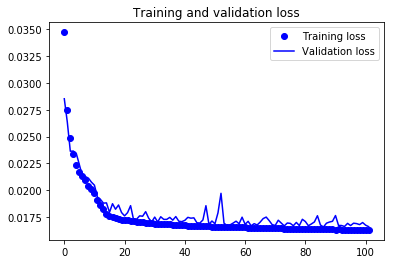

In [17]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(102)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

autoencoder.save('feb_epochs{}_batch{}_{}_{}.h5'.format(n_epochs, batch_size, optimizer, loss[-1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


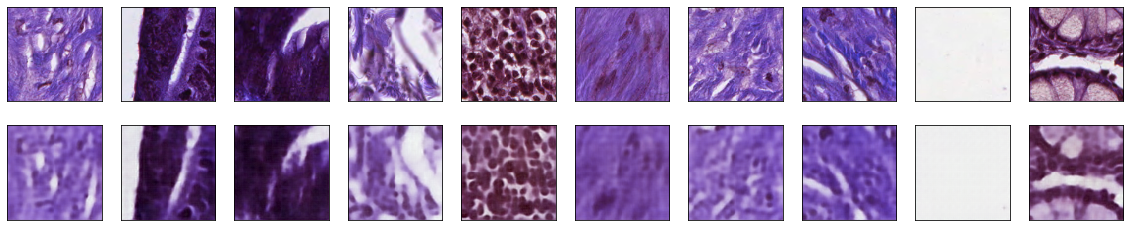

In [16]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
cuda.select_device(0)
cuda.close()

In [13]:
autoencoder_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
__________

(20000, 6, 6, 16)
(20000, 576)


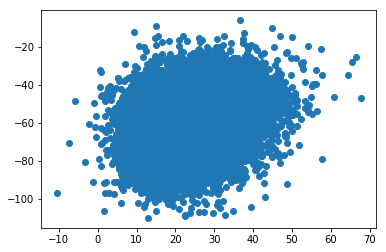

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

layer_name = 'conv2d_7'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)

encoded_imgs = intermediate_layer_model.predict(x_test)
print(encoded_imgs.shape)
encoded_imgs = encoded_imgs.reshape((len(x_test),-1))
print(encoded_imgs.shape)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1])

(20000, 50)


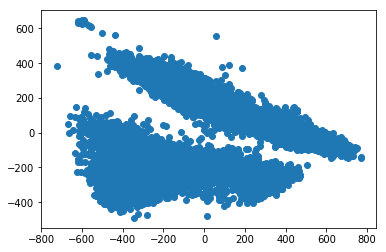

In [19]:
pca = PCA(n_components=50)
pcatransformedData = pca.fit_transform(encoded_imgs)
print(pcatransformedData.shape)
plt.scatter(pcatransformedData[:, 0], pcatransformedData[:, 1])

(20000, 2)


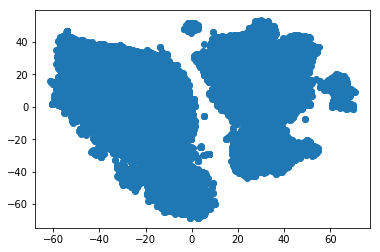

In [17]:
tsne = TSNE(n_components=2)
transformedData = tsne.fit_transform(pcatransformedData)

print(transformedData.shape)
plt.scatter(transformedData[:, 0], transformedData[:, 1])